In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd

In [22]:
def MEG_gradient(X, time, N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_overall_conc, Pase_grad, PLK1_overall_conc, PLK1_grad):
    
    x=2*PLK1_overall_conc/(2-PLK1_grad)
    PLK_conc = np.linspace((1-PLK1_grad)*x, x, N)
    
    x=2*Pase_overall_conc/(2-Pase_grad)
    Pase_conc = np.linspace(x,(1-Pase_grad)*x, N)
    
    dx=np.zeros(4*N)
    
    # equations for M - dx[0 to N-1] is M conc in cpts 0 to N-1
    for i in range(N):
        
        if i==0:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i+1]-X[i])
        
        elif i==N-1:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i-1]-X[i])
            
        else:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i+1]+X[i-1]-2*X[i]) 
    
    # equations for MP - dx[N to 2N-1] is M conc in cpts 0 to N-1
    
    for i in range(N):
        
        if i==0:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N+1]-X[i+N])
        
        elif i==N-1:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N-1]-X[i+N])
            
        else:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N+1]+X[i+N-1]-2*X[i+N]) 
    
    # equations for R - dx[2*N to 3N-1] is R conc in cpts 0 to N-1
    
    for i in range(N):
        
        dx[i+2*N]=-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+kcat2_km2*PLK_conc[i]*X[i+3*N]
        
    
    # equations for MR - dx[3*N to 4N-1] is MR conc in cpts 0 to N-1
    
    for i in range(N):
        
        if i==0:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N+1]-X[i+3*N])
        
        elif i==N-1:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N-1]-X[i+3*N])
            
        else:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N+1]+X[i+3*N-1]-2*X[i+3*N]) 
    
    return dx

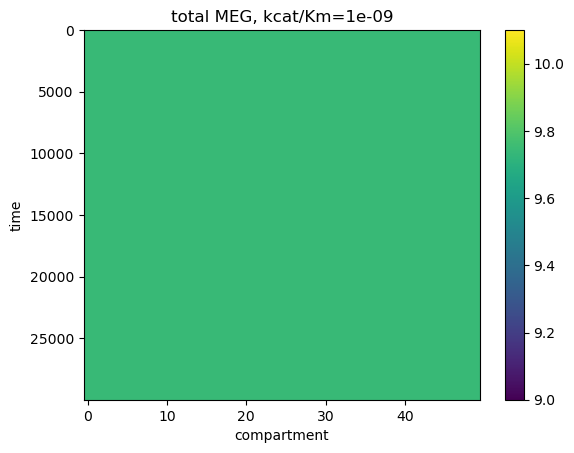

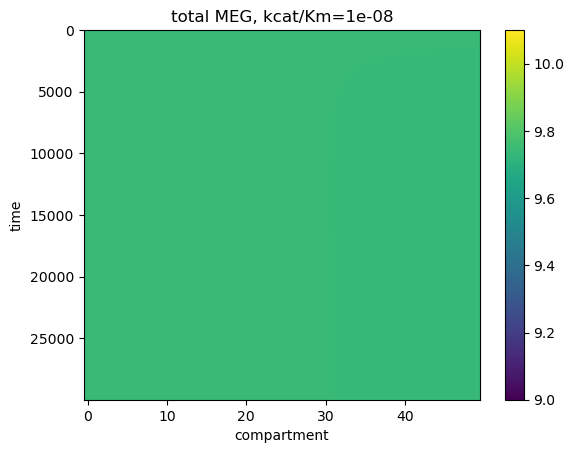

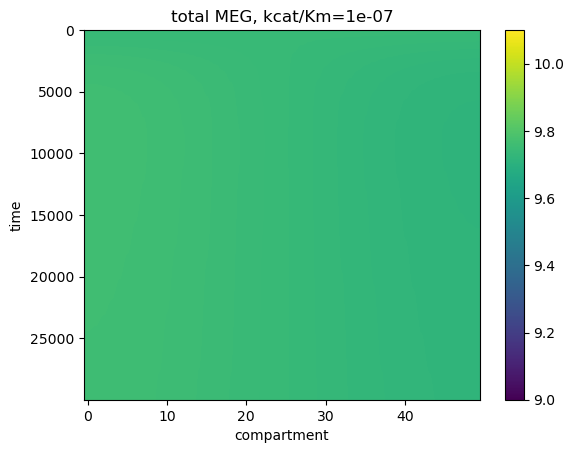

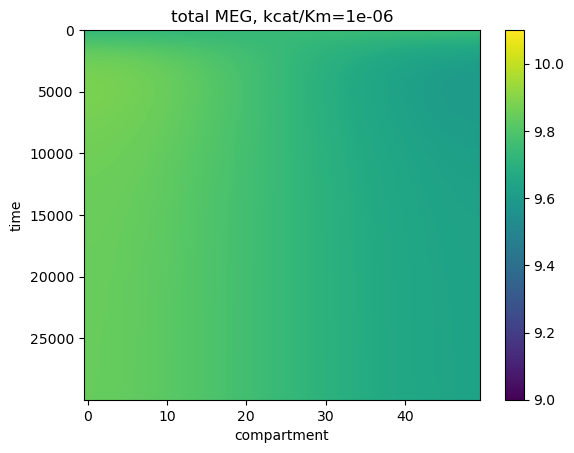

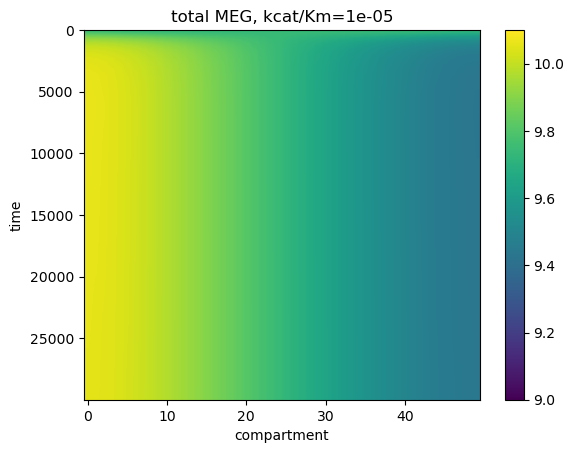

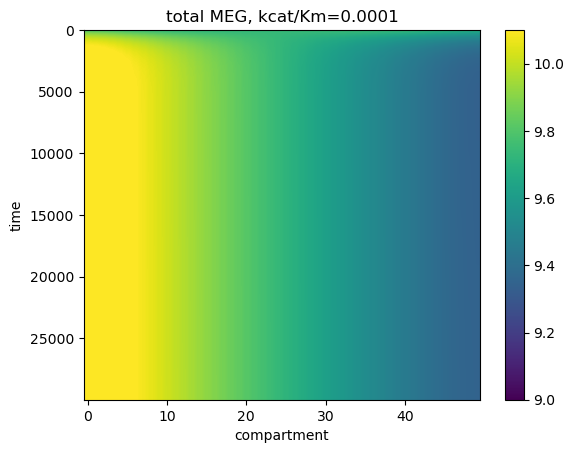

In [23]:
# Phosphatase equal conc. and kcat/Km to PLK-1 and uniformly distributed
# varying kcat/km from literature

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

    
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

gradient_strength = []
kcat_km_values = [10**(-9), 10**(-8), 10**(-7), 10**(-6), 10**(-5), 10**(-4)]

for count, kcat_km in enumerate(kcat_km_values):
    
    params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params) 
    
    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    gradient_strength.append(1-anterior_MEG/posterior_MEG)
    
    total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]    
    cs = plt.imshow(total_MEG, aspect='auto', vmin=9.0, vmax=10.1)
    plt.title(f'total MEG, kcat/Km={kcat_km}')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.colorbar(cs)
    plt.show()

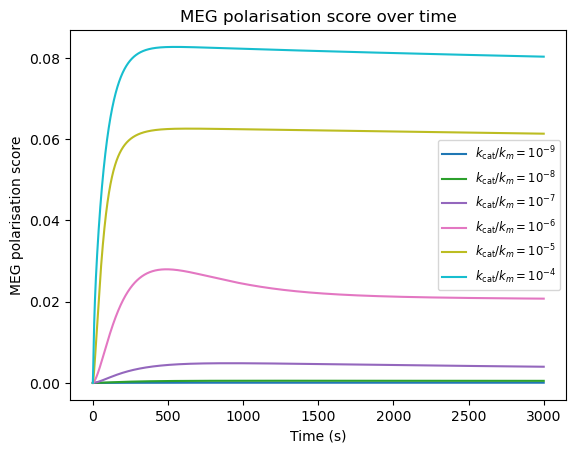

In [28]:
def format_scientific_notation(num):
    """
    Manually formats a number into '10^{exponent}' notation.
    """
    if num == 0:
        return "10^{0}"
    exponent = int(np.floor(np.log10(abs(num))))
    return r'10^{{{}}}'.format(exponent)

color = plt.cm.tab10(np.linspace(0, 1, len(kcat_km_values)))

for i, color_val in zip(range(len(kcat_km_values)), color):
    formatted_value = format_scientific_notation(kcat_km_values[i])
    label = r'$k_{\text{cat}}/k_m=' + formatted_value + r'$'
    plt.plot(t, gradient_strength[i], label=label, color=color_val)

plt.legend(loc='best', fontsize='small')
plt.xlabel('Time (s)')
plt.ylabel('MEG polarisation score')
plt.title("MEG polarisation score over time")

plt.savefig("MEG_pol_score_over_time.pdf")
plt.show()
plt.close()

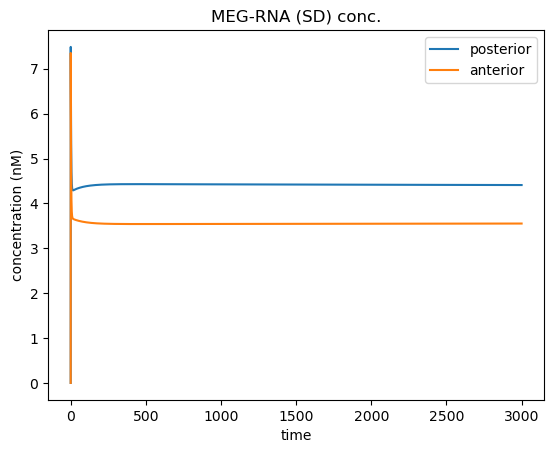

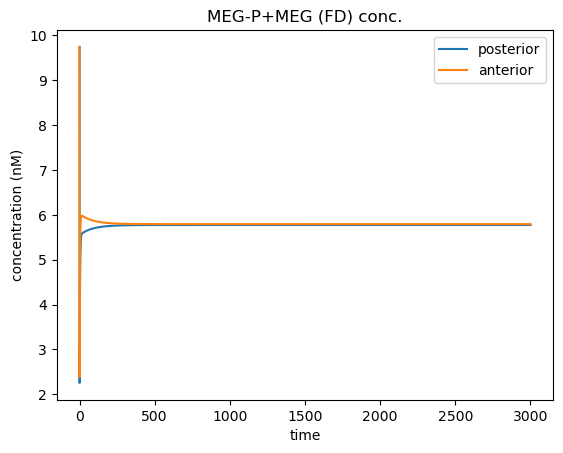

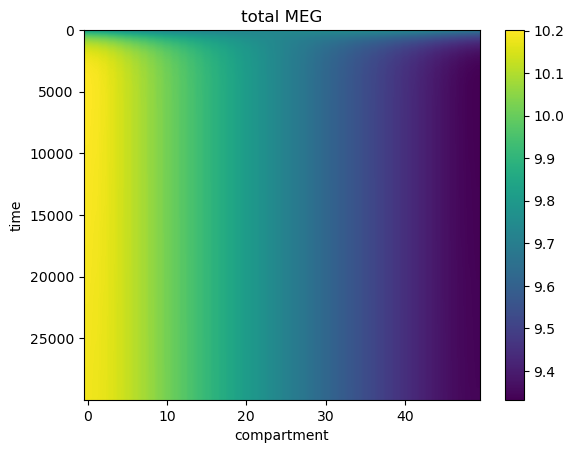

Text(0.5, 1.0, 'MEG gradients over time')

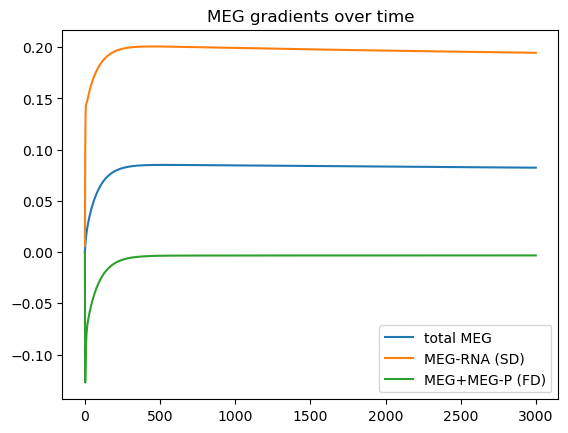

In [5]:
# taking kcat/km=1.8*10^(-4) (highest value for PLK-1 from literature)

kcat_km=1.8*10**(-4)
params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

plt.plot(t, sol[:, 3*N], label="posterior")
plt.plot(t, sol[:, 4*N-1], label="anterior")
plt.title('MEG-RNA (SD) conc.')
plt.xlabel('time')
plt.ylabel('concentration (nM)')
plt.legend()
plt.show()

plt.plot(t, sol[:,0]+sol[:, N], label="posterior")
plt.plot(t, sol[:,N-1]+sol[:, 2*N-1], label="anterior")
plt.title('MEG-P+MEG (FD) conc.')
plt.xlabel('time')
plt.ylabel('concentration (nM)')
plt.legend()
plt.show()

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
MEG_gradient_strength=1-anterior_MEG/posterior_MEG

posterior_SD = sol[1:, 3*N]
anterior_SD = sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD

posterior_FD = sol[:, 0]+sol[:, N]
anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
FD_gradient_strength=1-anterior_FD/posterior_FD

plt.plot(t, MEG_gradient_strength, label="total MEG")
plt.plot(t[1:], SD_gradient_strength, label="MEG-RNA (SD)")
plt.plot(t, FD_gradient_strength, label="MEG+MEG-P (FD)")
plt.legend(loc='best')
plt.title("MEG gradients over time")

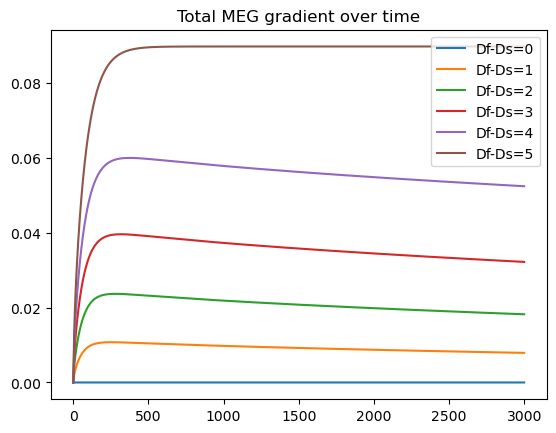

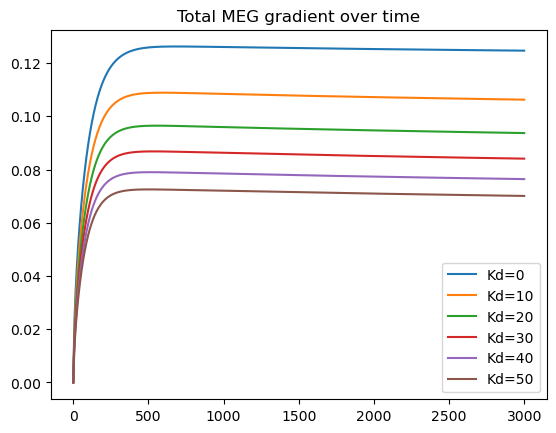

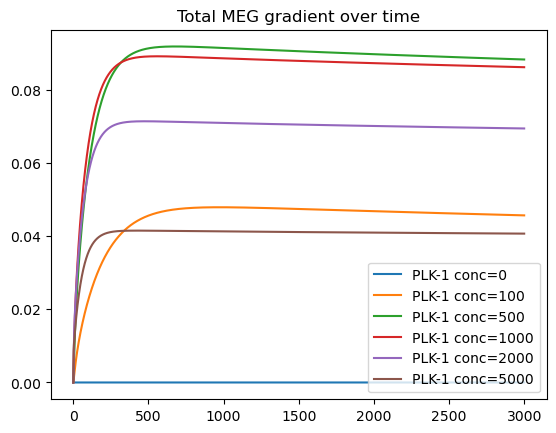

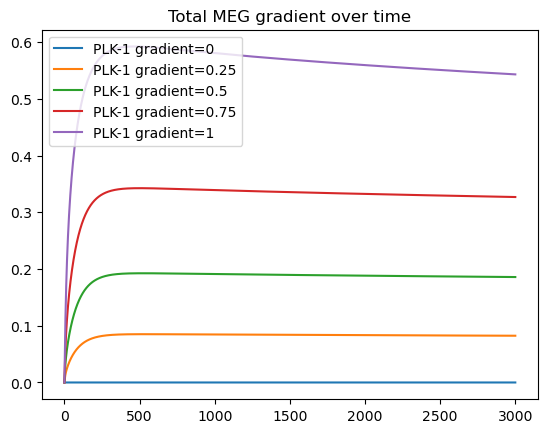

In [55]:
# seeing how the fixed parameters (not concerning phosphatase) contribute to the gradient

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

# changing the difference between Df and Ds
Df=5

for i in range(6):
    Ds=Df-i
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    plt.plot(t, MEG_gradient_strength, label=f"Df-Ds={i}")
    
plt.legend(loc='best')
plt.title("Total MEG gradient over time")
plt.show()

# Changing Kd for MEG RNA binding
Df=5
Ds=0.11

for Kd in (0, 10, 20, 30, 40, 50):
    k2=k1*Kd
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    plt.plot(t, MEG_gradient_strength, label=f"Kd={Kd}")

plt.legend(loc='best')
plt.title("Total MEG gradient over time")
plt.show()

# Changing PLK-1 conc
k2=32*k1

for PLK1 in (0, 100, 500, 1000, 2000, 5000):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    plt.plot(t, MEG_gradient_strength, label=f"PLK-1 conc={PLK1}")

plt.legend(loc='best')
plt.title("Total MEG gradient over time")
plt.show()

# Changing PLK-1 gradient

for PLK1_gradient in (0, 0.25, 0.5, 0.75, 1):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_gradient)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    plt.plot(t, MEG_gradient_strength, label=f"PLK-1 gradient={PLK1_gradient}")

plt.legend(loc='best')
plt.title("Total MEG gradient over time")
plt.show()

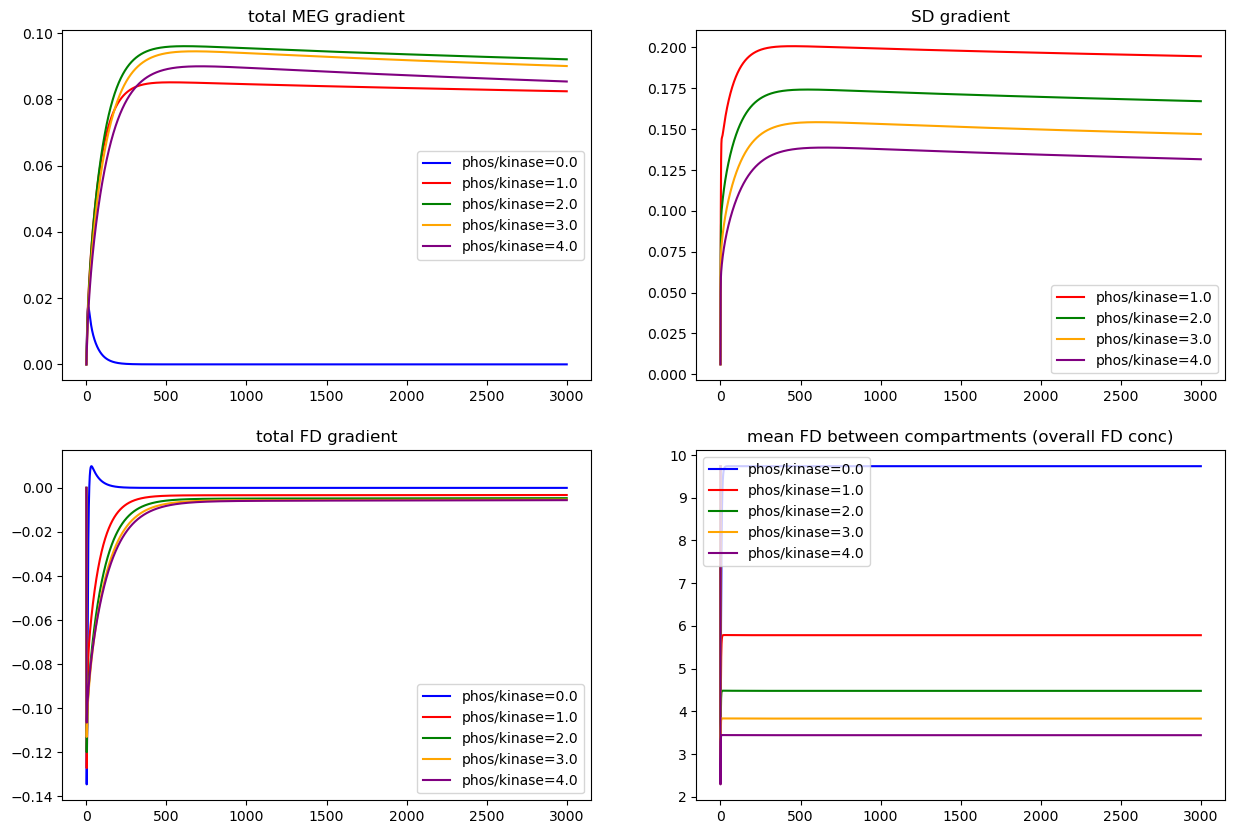

In [38]:
# varying phosphatase parameters

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

# changing phosphatase concentration when phosphatase is uniform

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

for count, phos_conc in enumerate(range(0, 5000, 1225)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

# see below for more

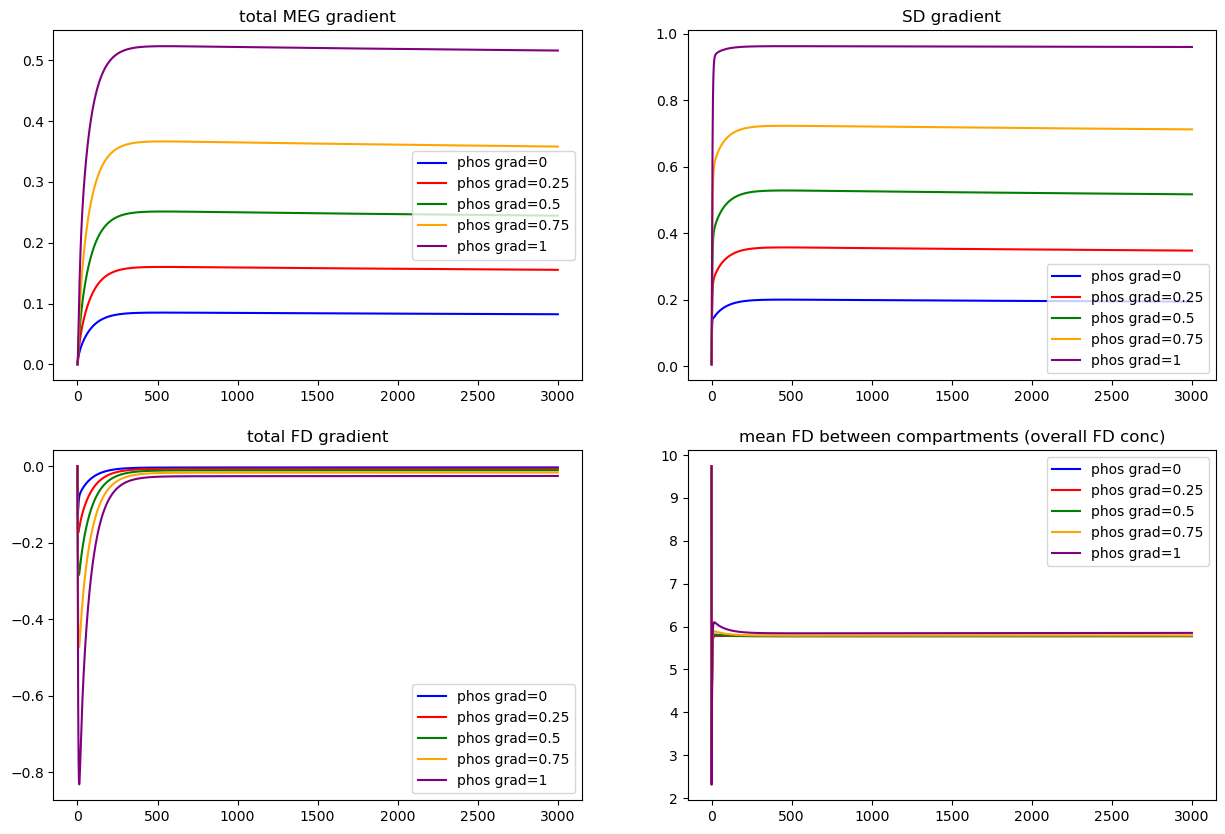

In [36]:
# changing the gradient of phosphatase

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

for count, phos_gradient in enumerate((0, 0.25, 0.5, 0.75, 1)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, phos_gradient, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos grad={phos_gradient}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos grad={phos_gradient}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos grad={phos_gradient}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos grad={phos_gradient}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

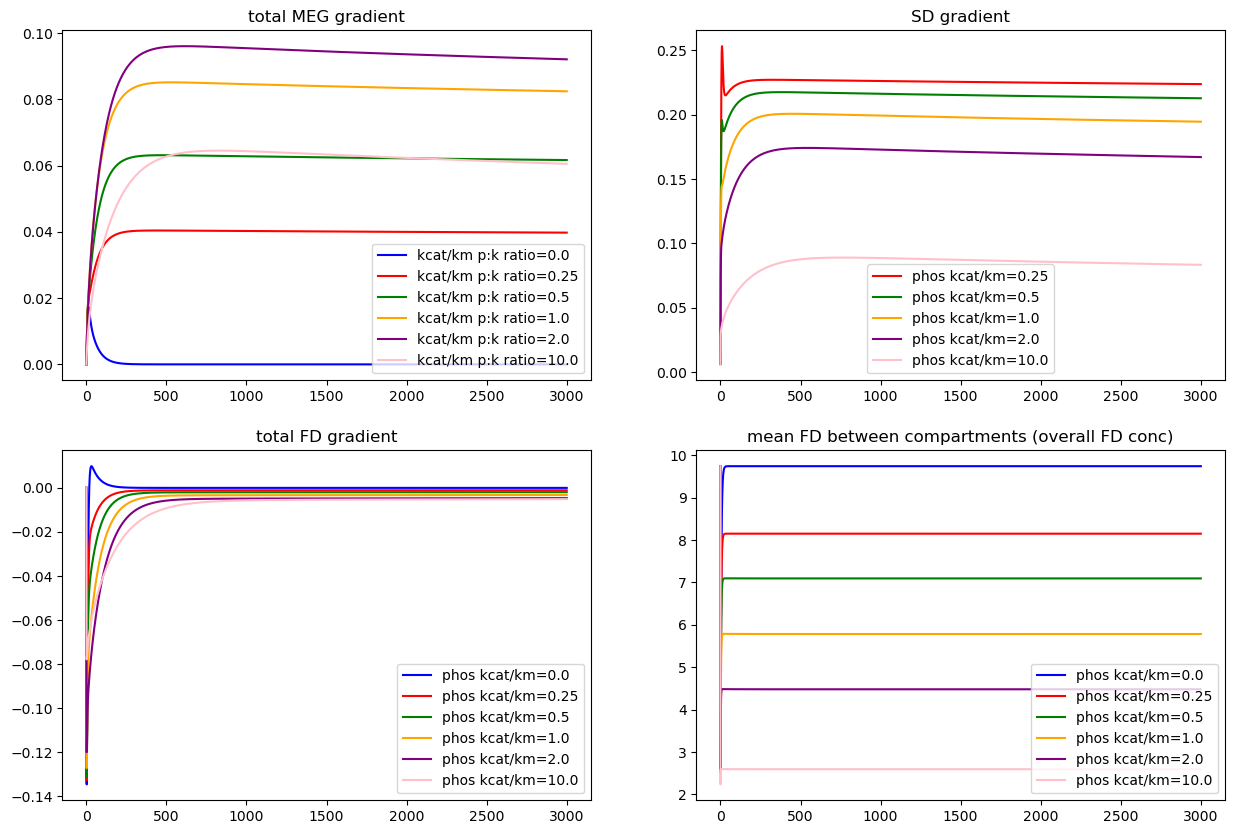

In [10]:
# changing phosphatase kcat/km when phosphatase is uniform

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']

for count, phos_kinetics in enumerate((0, 0.25*kcat2_km2, 0.5*kcat2_km2, kcat2_km2, 2*kcat2_km2, 10*kcat2_km2)):
    params=(N, phos_kinetics, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"kcat/km p:k ratio={phos_kinetics/kcat2_km2}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_kinetics != 0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos kcat/km={phos_kinetics/kcat2_km2}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos kcat/km={phos_kinetics/kcat2_km2}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos kcat/km={phos_kinetics/kcat2_km2}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

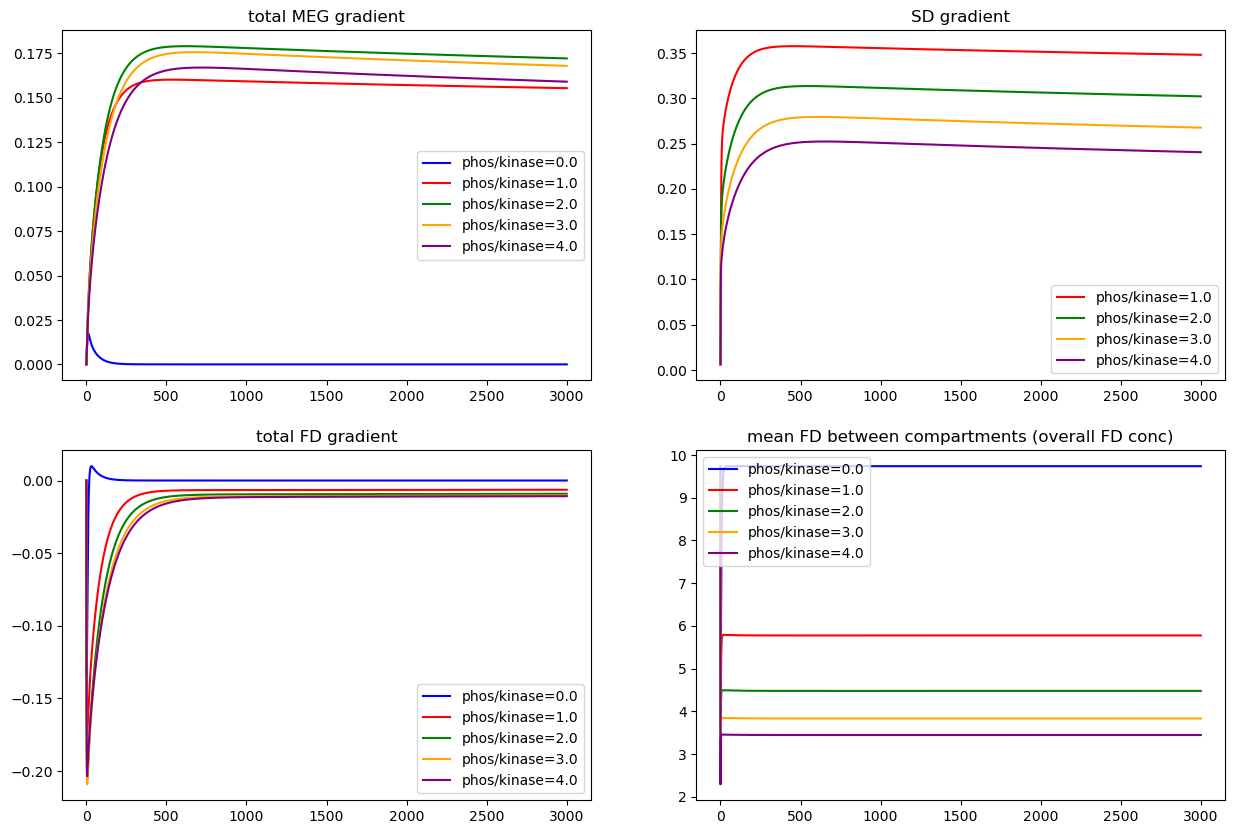

In [44]:
# changing phosphatase concentration when phosphatase is uniform
Pase_grad=0.25

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

for count, phos_conc in enumerate(range(0, 5000, 1225)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

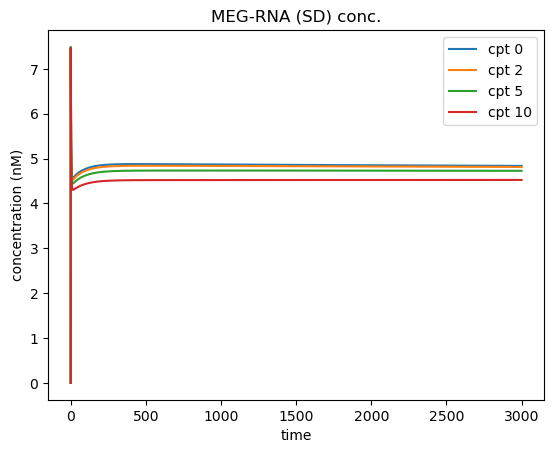

In [46]:
# seeing if SD is highest in posterior or just before posterior
# notes Wu et al measure relative number of molecules, not concentrations - here we are dealing with concentrations

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.25
PLK1_conc=1225
PLK1_grad=0.25

params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

plt.plot(t, sol[:, 3*N], label="cpt 0")
plt.plot(t, sol[:, 3*N+2], label="cpt 2")
plt.plot(t, sol[:, 3*N+5], label="cpt 5")
plt.plot(t, sol[:, 3*N+10], label="cpt 10")
plt.title('MEG-RNA (SD) conc.')
plt.xlabel('time')
plt.ylabel('concentration (nM)')
plt.legend()
plt.show()